In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
SincP = 1.0

# source output
def wsrc(t):
    return np.sinc(SincP*t)

# helper functions
def dist(src,x,y):
    (x0,y0) = src
    return np.sqrt((x0-x)**2+(y0-y)**2)

def dist_obj(src,obj,x,y):
    (x0,y0) = src
    (x1,y1) = obj
    return np.sqrt((x0-x1)**2+(y0-y1)**2)+np.sqrt((x1-x)**2+(y1-y)**2)

In [6]:
class Setup():
    def __init__(self,src, obstacle, Nmics, Nsamp, dist_per_samp, C, pitch):
        self.src = src
        self.obstacle = obstacle
        self.Nmics = Nmics
        self.Nsamp = Nsamp
        self.dist_per_samp = dist_per_samp
        self.C = C
        self.pitch = pitch
        
        self.find_mic_positions()
    

    def find_mic_positions(self):
        self.mics = []
        for n in range(self.Nmics):
            self.mics.append(self.pitch/2 + (n-self.Nmics/2)*self.pitch)
        self.mics = np.array(self.mics)
        # print(self.mics)
        
    
    def display_wave_output(self):
        
        self.xRES, self.yRES = 200,200
        self.xMAX = max(self.obstacle[0]*1.5,5)
        self.xMIN = -self.xMAX/5
        self.yMAX = max(max(self.mics[-1],self.obstacle[1])*1.5,1)
        self.yMIN = min(min(self.mics[0],self.obstacle[1])*1.5,-1)
        self.xSTEP = (self.xMAX-self.xMIN)/self.xRES
        self.ySTEP = (self.yMAX-self.yMIN)/self.yRES
        
        tsamp = 0

        x = np.arange(self.xMIN,self.xMAX,self.xSTEP)
        y = np.arange(self.yMIN,self.yMAX,self.ySTEP)

        while tsamp < self.Nsamp:
            X, Y = np.meshgrid(x, y)
            d = dist(self.src,X,Y)
            t = d/(self.dist_per_samp*self.C)
            
            d2 = dist_obj(self.src,self.obstacle,X,Y)
            t2 = d2/(self.dist_per_samp*self.C)
            
            z = (wsrc(tsamp-t)+wsrc(tsamp-t2))
            # z = (wsrc(tsamp-t))
                
            plt.clf()
            plt.imshow(z,cmap='plasma',vmin=0,vmax=1,extent=(x.min(), x.max(), y.min(), y.max()))
            
            # for i in range(Nmics):
            #     circle = plt.Circle((0, (mics[i]-yMIN)*yRES/(yMAX-yMIN)), 10, color='white', fill=True)
            #     plt.gca().add_patch(circle)
                
            # plt.pause(0.5)
            plt.pause(0.01)
            
            
            tsamp+=1
        
    def find_mic_data(self):
        self.mic_data = np.zeros((self.Nmics,1))
        tsamp = 0
        while tsamp < self.Nsamp:
            tmics = dist(self.src,0,self.mics)/(self.dist_per_samp*self.C)
            tmics2 = dist_obj(self.src,self.obstacle,0,self.mics)/(self.dist_per_samp*self.C)
            
            # zmic =  wsrc(tsamp-tmics)+wsrc(tsamp-tmics2)
            # zmic =  wsrc(tsamp-tmics)
            zmic =  wsrc(tsamp-tmics2)
            
            zmic = zmic.reshape(-1,1)
            self.mic_data = np.hstack((self.mic_data,zmic))
            
            tsamp += 1
            
        self.mic_data = np.delete(self.mic_data,0, axis=1)
    
    def plot_mic_data(self):
        t = np.arange(0,self.Nsamp,1)
        plt.figure(figsize=(5,5))
        print(self.mic_data.shape)
        for i in range(self.Nmics):
            plt.plot(t,self.mic_data[i])
            # if i==10:
            #     break
        plt.show()
 
    def digital_output(self,mic_data,d):
        i = ((d/(self.dist_per_samp*self.C)).astype(int))%self.Nsamp
        return mic_data[i]       
    
    def DAS(self, mic_data, xmax=5,ymax=5,resolution=200, display=True):
        tsamp = 0
        self.xRES, self.yRES = resolution,resolution
        self.xMAX = xmax
        self.xMIN = 0
        self.yMAX = ymax
        self.yMIN = -ymax
        self.xSTEP = (self.xMAX-self.xMIN)/self.xRES
        self.ySTEP = (self.yMAX-self.yMIN)/self.yRES
        
        x = np.arange(self.xMIN,self.xMAX,self.xSTEP)
        y = np.arange(self.yMIN,self.yMAX,self.ySTEP)
        
        Nmics, Nsamp = mic_data.shape
        mx = -10000
        zmx = np.full((self.xRES,self.yRES),0, dtype=np.float64)
        # print(self.mics)
        
        X, Y = np.meshgrid(x, y)
        for i in range(Nmics):
            # print(mic_data.shape,X.shape,Y.shape)
            d = dist((0,self.mics[i]),X,Y)
            zmx += self.digital_output(mic_data[i],d-tsamp*self.dist_per_samp*self.C)
            
        if display:   
            print(tsamp)
            plt.clf()
            plt.imshow(z,cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
            # plt.imshow(z,cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
            
            # for i in range(Nmics):
            #     circle = plt.Circle((0, (mics[i]-yMIN)*yRES/(yMAX-yMIN)), 10, color='white', fill=True)
            #     plt.gca().add_patch(circle) 
                
            plt.axis([self.xMIN, self.xMAX, self.yMIN, self.yMAX])
            plt.pause(0.01)
    
        tsamp+=1
        mx_ind = np.unravel_index(np.argmax(zmx), zmx.shape) 
        print(mx_ind[1]*self.xSTEP-abs(self.xMIN),mx_ind[0]*self.ySTEP-abs(self.yMAX))
        self.zmx = zmx
    
    def plot_DAS(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.zmx,cmap='plasma',extent=(self.xMIN, self.xMAX, self.yMIN, self.yMAX))
        plt.show()
    
    def plot_3D(self):
        x = np.arange(self.xMIN,self.xMAX,self.xSTEP)
        y = np.arange(self.yMIN,self.yMAX,self.ySTEP)
        X, Y = np.meshgrid(x, y)
        Z = self.zmx
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='plasma')

        # Labelsz
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Intensity')

        # Show plot
        plt.show()

1.1500000000000001 4.9
(64, 200)


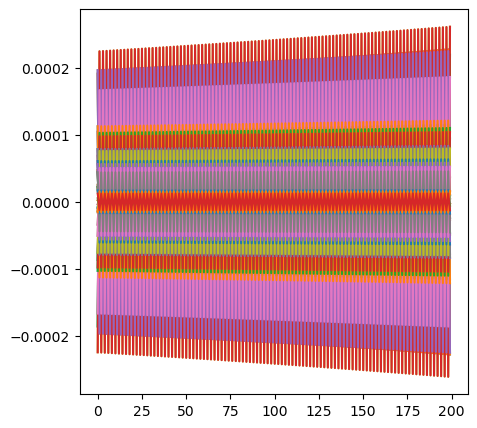

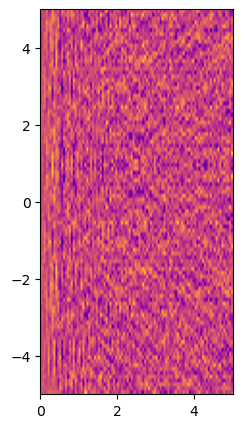

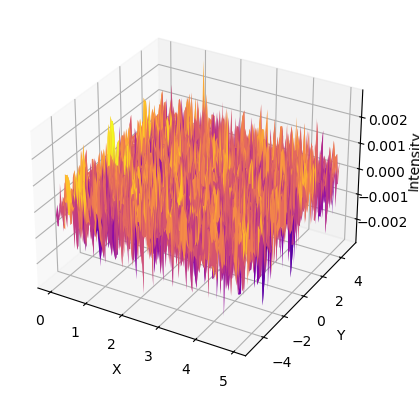

In [7]:
Nmics = 64
Nsamp = 200

pitch = 1
dist_per_samp = 0.05
C = 0.1

src = (0,0)
obstacle = (3,-1)

setup = Setup(src, obstacle, Nmics, Nsamp, dist_per_samp, C, pitch)
setup.find_mic_data()
# setup.display_wave_output()
setup.DAS(setup.mic_data,ymax=5,xmax=5,resolution=100,display=False)
setup.plot_mic_data()
setup.plot_DAS()
setup.plot_3D()


(64, 200)
17.0 -0.7999999999999998
69


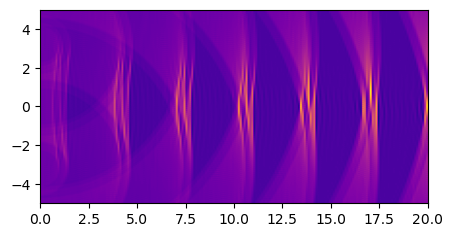

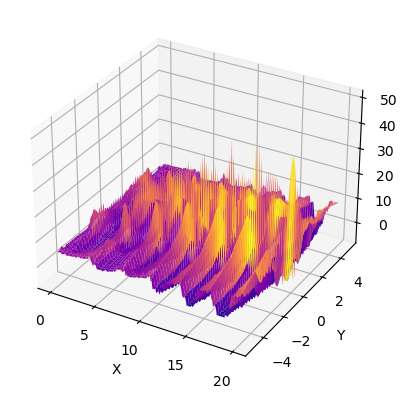

In [8]:

rx2 = np.loadtxt('rx3.txt')
# rx2 = rx2[[0,10,16]]

print(rx2.shape)
Nmics, Nsamp = rx2.shape

pitch = 0.1
dist_per_samp = 0.08
C = 0.2

src = (0,0)
obstacle = (-1,-1)

setup = Setup(src, obstacle, Nmics, Nsamp, dist_per_samp, C, pitch)

setup.mic_data = rx2

import time
t1 = time.time()
setup.DAS(rx2,ymax=5,xmax=20,resolution=200,display=False)
t2 = time.time()

print(int(1000*(t2-t1)))
setup.plot_DAS()
setup.plot_3D()
